### Plots: Neighborhood level characteristics


In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec

from PIL import Image
import io


plt.style.use('ggplot')
%matplotlib inline

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    # colorbar
    if len(heat) != 0:

         # Separate positive and negative values for different color maps
        pos_norm = mpl.colors.Normalize(vmin=0, vmax=max(heat.values()))
        neg_norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=0)

        # Define two color maps
        pos_cm = plt.get_cmap('Reds')
        neg_cm = plt.get_cmap('Blues_r')



        # Create and set the ScalarMappable objects for colorbars
        pos_sm = plt.cm.ScalarMappable(cmap=pos_cm, norm=pos_norm)
        neg_sm = plt.cm.ScalarMappable(cmap=neg_cm, norm=neg_norm)
        pos_sm.set_array([])
        neg_sm.set_array([])

        # Display the colorbars
        plt.colorbar(pos_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(neg_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = (1,1,1,1)
        else:
            if loc_id not in heat:
                col = (1, 1, 1, 1)  # Default color if no data
            else:
                heat_value = heat[loc_id]
                if heat_value > 0:
                    col = pos_cm(pos_norm(heat_value))
                elif heat_value < 0:
                    col = neg_cm(neg_norm(heat_value))
                else:
                    col = (1,1,1,1)


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        if len(text) != 0 and loc_id in text:
            plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def draw_zone_income(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=max(heat.values()))
        cm = plt.get_cmap('YlGnBu')  # Blue to yellow color map
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        if len(heat) == 0 or loc_id not in heat:
            col = (1, 1, 1, 1)  # Default color for no data
        else:
            col = cm(norm(heat[loc_id]))


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        if len(text) != 0 and loc_id in text:
            plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def plot_parks_beaches(ax, sf, zones={}):
    ocean_color = (89/256, 171/256, 227/256)  # RGB color for the ocean background
    ax.set_facecolor(ocean_color)

    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]  # Adjust 'location_i' as per your shapefile's record keys

        # Set color: green for zones with value 1, white otherwise
        col = 'green' if zones.get(loc_id, 0) == 1 else 'white'

        nparts = len(shape.parts)  # Total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else:  # Loop over parts of each shape, plot separately
            for ip in range(nparts):
                i0 = shape.parts[ip]
                i1 = shape.parts[ip + 1] - 1 if ip < nparts - 1 else len(shape.points)

                polygon = Polygon(shape.points[i0:i1 + 1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)

    # Adjust plot limits to fit the shapes
    limits = get_boundaries(sf)  # Assuming get_boundaries is a function you have defined elsewhere
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Load Taxi zone shapefile and socioeconomic data at the taxi zone level

In [43]:
# Read the taxizone shapefile
sf = shapefile.Reader("Data/Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")

socioeconomic = pd.read_csv("Data/ACS_data/taxi_zones_ACS_parks_beaches_deviation.csv")

##### Plot Parks and Beaches

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


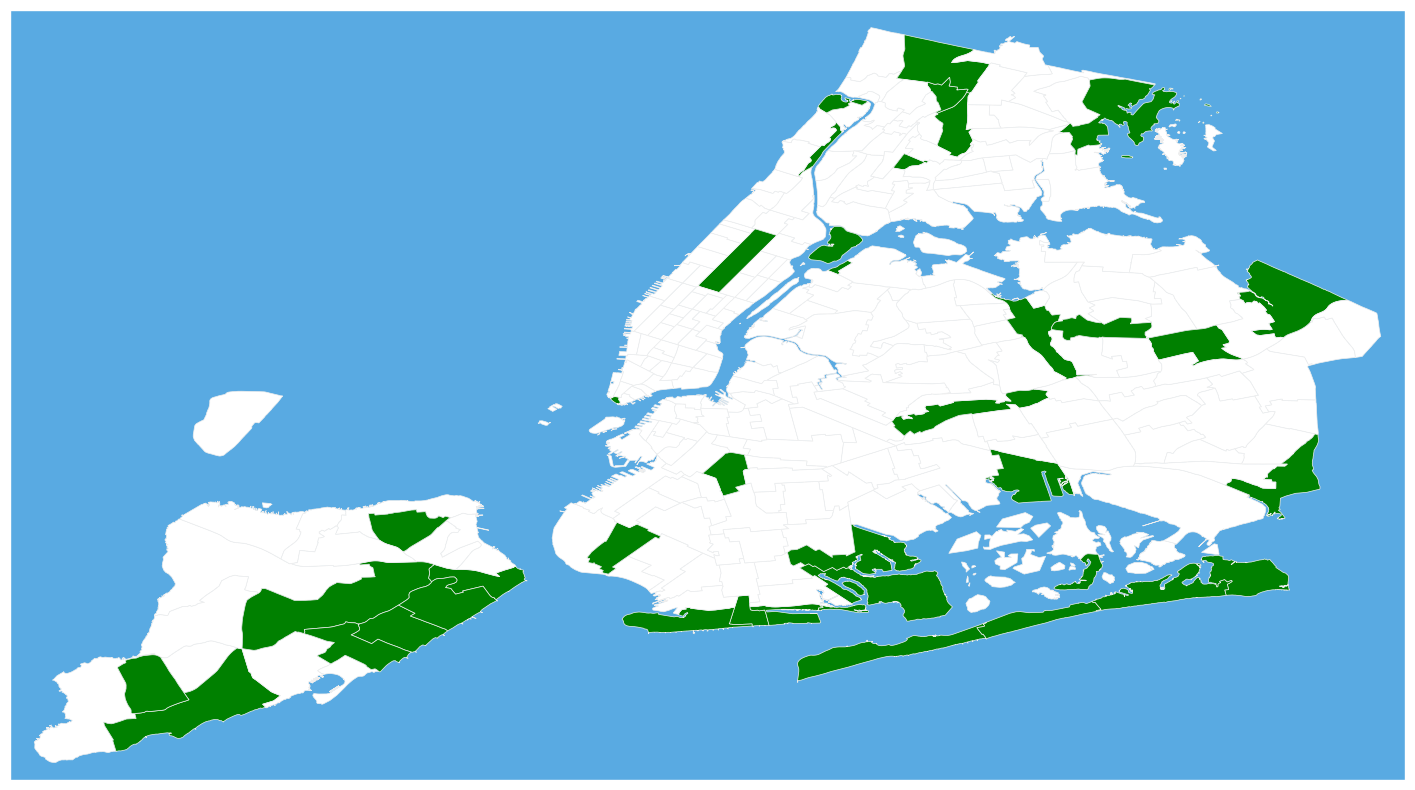

In [44]:

socioeconomic['park_beach'] = ((socioeconomic['park_coverage'] > 20) | (socioeconomic['beach_coverage'] > 0)).astype(int)

# set zones 155 and 154 and 30, 124 to 1 manually : Park and Beach Zones
socioeconomic.loc[socioeconomic['location_i'].isin([155,154,30,124]), 'park_beach'] = 1
heat_deviation = dict(zip(socioeconomic['location_i'].tolist(), socioeconomic['park_beach'].tolist()))
# remove nan values from dictionary
heat_deviation = {k: v for k, v in heat_deviation.items() if not math.isnan(v)}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
# Plot
plot_parks_beaches(ax,sf,heat_deviation)

#### Plot socioeconomic statistics

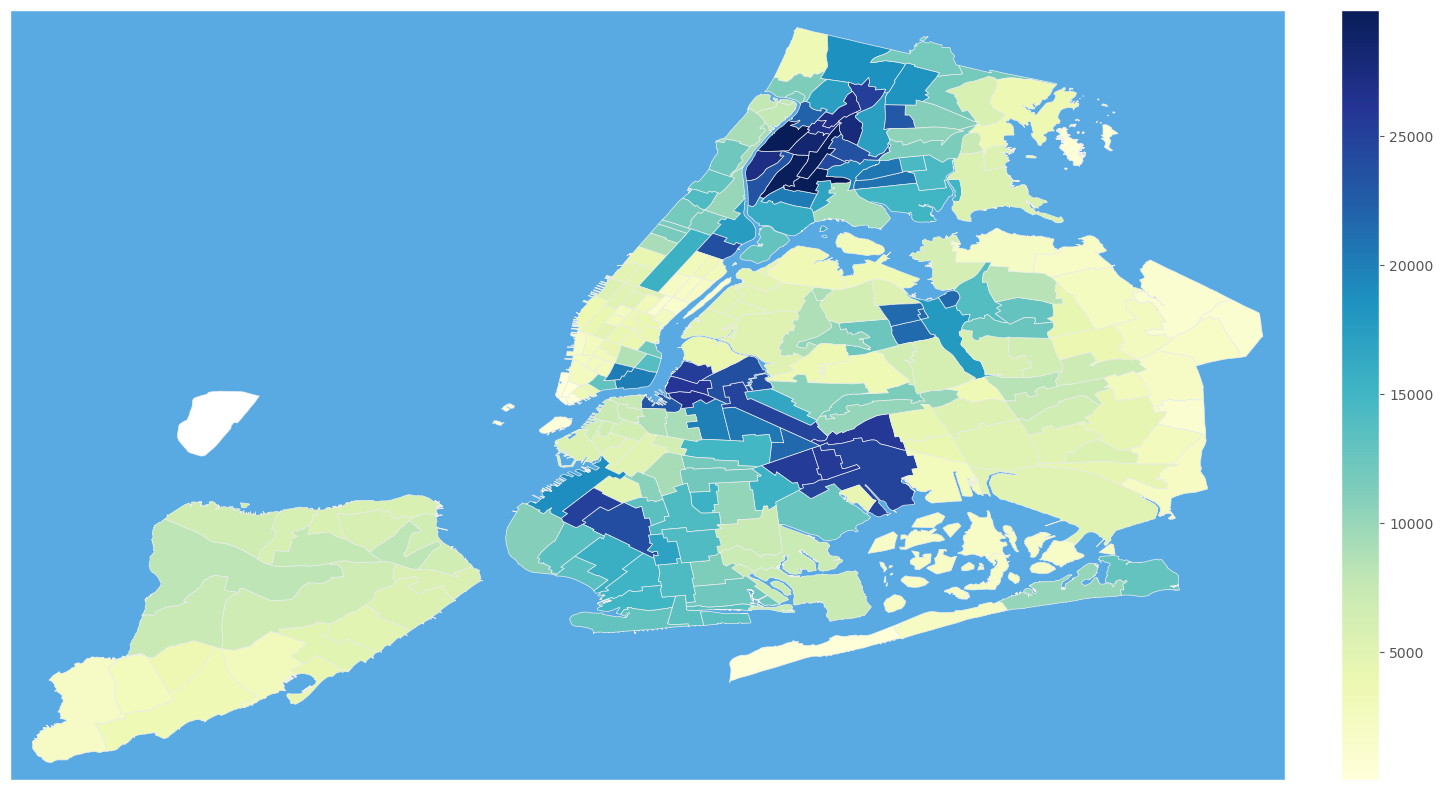

In [46]:
# Define

variable = "fpl_100"

heat_deviation = dict(zip(socioeconomic['location_i'].tolist(), socioeconomic[variable].tolist()))
# remove nan values from dictionary
heat_deviation = {k: v for k, v in heat_deviation.items() if not math.isnan(v)}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))

draw_zone_income(ax, sf, heat=heat_deviation)